In [34]:
import pandahouse
import hashlib
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [1]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT distinct user_id
FROM simulator_20240620.feed_actions 
WHERE toDate(time) >= '2024-06-15' and toDate(time) <= '2024-06-21' 
"""

# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

In [12]:
# Сделали группы
users_df['hash_group'] = users_df.user_id.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,12605
1,1,12297
2,2,12491
3,3,12307
4,4,12581


In [13]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20240620.feed_actions  
WHERE toDate(time) between '2024-06-08' and '2024-06-14'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,11517,11517,11517,11517
3,11722,11722,11722,11722


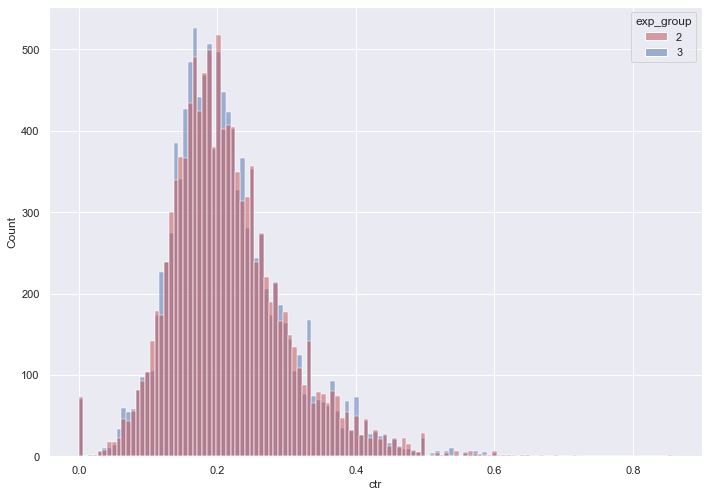

In [16]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [19]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=1.1340172769310652, pvalue=0.25679900606652634)

In [20]:
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=68217982.5, pvalue=0.16092395961547257)
Отличие не прокрасилось
В 50.5 % случаев A > B. Должно получиться около 50%


In [23]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20240620.feed_actions  
WHERE toDate(time) between '2024-05-24' and '2024-05-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)


In [24]:

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


In [32]:
p_values = []
for i in range(10000):
    subsample_2 = np.random.choice(df[df.exp_group == 2].ctr, size=500, replace=False)
    subsample_3 = np.random.choice(df[df.exp_group == 3].ctr, size=500, replace=False)
    p_values.append(stats.ttest_ind(subsample_2, subsample_3, equal_var=False).pvalue)

(array([304., 330., 347., 329., 329., 315., 351., 287., 332., 319., 330.,
        328., 307., 321., 348., 344., 335., 339., 326., 332., 340., 330.,
        377., 351., 349., 342., 350., 363., 320., 325.]),
 array([3.82580534e-04, 3.37008798e-02, 6.70191790e-02, 1.00337478e-01,
        1.33655777e-01, 1.66974077e-01, 2.00292376e-01, 2.33610675e-01,
        2.66928974e-01, 3.00247274e-01, 3.33565573e-01, 3.66883872e-01,
        4.00202171e-01, 4.33520470e-01, 4.66838770e-01, 5.00157069e-01,
        5.33475368e-01, 5.66793667e-01, 6.00111967e-01, 6.33430266e-01,
        6.66748565e-01, 7.00066864e-01, 7.33385163e-01, 7.66703463e-01,
        8.00021762e-01, 8.33340061e-01, 8.66658360e-01, 8.99976660e-01,
        9.33294959e-01, 9.66613258e-01, 9.99931557e-01]),
 <BarContainer object of 30 artists>)

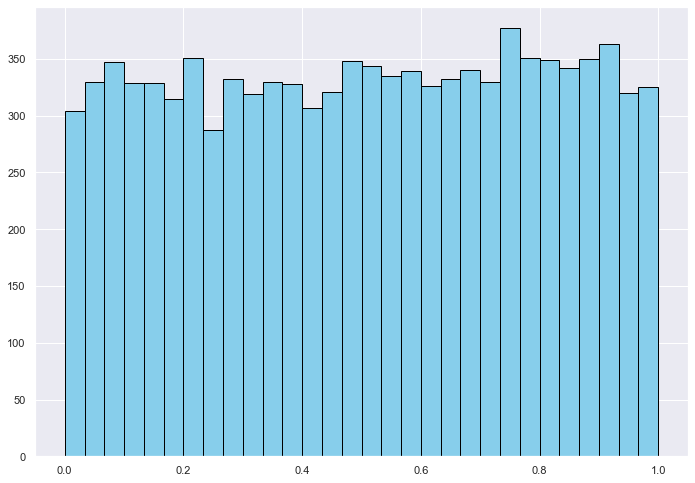

In [35]:
plt.hist(p_values, bins=30, color='skyblue', edgecolor='black')

In [37]:
len([i for i in p_values if i <= 0.05]) / len(p_values) * 100

4.53